## Installation und Einrichtung
Bevor du startest, stelle sicher, dass du die folgenden Pakete installiert hast. Führe in einer Jupyter-Notebook-Zelle Folgendes aus:

``pip install stable-baselines3 pandas matplotlib``

stable-baselines3: Für Reinforcement Learning.
pandas: Für die Datenverarbeitung.
matplotlib: Für die grafische Darstellung.
ccxt: Für die API-Anbindung an Kryptobörsen wie Binance.

##  Datenimport und Vorbereitung
In dieser Zelle holen wir die historischen Bitcoin-Daten:

In [ ]:
import pandas as pd
import yfinance as yf

def fetch_bitcoin_data(start_date, end_date):
    """
    Ruft Bitcoin-Daten von Yahoo Finance für den angegebenen Zeitraum ab.

    Args:
        start_date (str): Startdatum im Format 'YYYY-MM-DD'.
        end_date (str): Enddatum im Format 'YYYY-MM-DD'.

    Returns:
        pd.DataFrame: DataFrame mit den historischen Kursdaten.
    """
    try:
        # Überprüfung der Datumsformate
        pd.to_datetime(start_date)
        pd.to_datetime(end_date)

        # Sicherstellen, dass start_date vor end_date liegt
        if start_date >= end_date:
            raise ValueError("Das Startdatum muss vor dem Enddatum liegen.")

        # Lade Daten von Yahoo Finance
        df = yf.download("BTC-USD", start=start_date, end=end_date, interval="1d")

        # Überprüfen, ob Daten zurückgegeben wurden
        if df.empty:
            raise ValueError("Keine Daten für den angegebenen Zeitraum verfügbar.")

        # Umbenennen der Spalten für Konsistenz
        df.rename(columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume"
        }, inplace=True)

        # Filtere die relevanten Spalten und setze den Zeitstempel als Index
        df = df[["open", "high", "low", "close", "volume"]]
        df.index.name = "timestamp"

        return df

    except Exception as e:
        print(f"Fehler beim Abrufen der Daten: {e}")
        return pd.DataFrame()

In [ ]:
# Abrufen der Daten
data = fetch_bitcoin_data('2018-01-01', '2023-12-01')
print(data.head())  # Zeige die ersten Zeilen der Daten

- **fetch_ohlcv**: Ruft Open, High, Low, Close, Volume (OHLCV) Daten ab.
- **timestamp**: Zeitstempel für jeden Tag.
- **close**: Schlusskurs, der für das Training verwendet wird

## Umgebung und Agent erstellen
Hier definieren wir die RL-Umgebung und den Agenten:

In [34]:
import gym
import numpy as np

class BitcoinPredictionEnv(gym.Env):
    def __init__(self, data, window_size=60, prediction_horizon=7):
        super(BitcoinPredictionEnv, self).__init__()
        self.data = data[['open', 'high', 'low', 'close', 'volume']].values
        self.window_size = window_size
        self.prediction_horizon = prediction_horizon
        self.current_step = window_size

        # Action Space: Vorhersage für die nächsten `prediction_horizon` Tage (relative Preisänderungen)
        self.action_space = gym.spaces.Box(
            low=-1, high=1, shape=(prediction_horizon,), dtype=np.float32
        )

        # Observation Space: Fenstergröße x Anzahl der Features
        n_features = self.data.shape[1]
        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(window_size, n_features), dtype=np.float32
        )

    def reset(self):
        self.current_step = self.window_size
        return self._get_observation()

    def _get_observation(self):
        """
        Gibt die letzten `window_size` Tage als normalisierte Beobachtung zurück.
        """
        window = self.data[self.current_step - self.window_size:self.current_step]
        normalized_window = (window - np.min(self.data, axis=0)) / (
            np.max(self.data, axis=0) - np.min(self.data, axis=0)
        )
        return normalized_window

    def step(self, action):
        """
        Führt die Vorhersage aus und berechnet die Belohnung.
        """
        # Abbruchbedingung
        if self.current_step + self.prediction_horizon >= len(self.data):
            done = True
            return self._get_observation(), 0, done, {}

        # Tatsächliche Kursentwicklung für die nächsten `prediction_horizon - 1` Tage
        actual_prices = self.data[self.current_step:self.current_step + self.prediction_horizon, 3]  # Schlusskurse
        actual_changes = (actual_prices - actual_prices[0]) / actual_prices[0]  # 7 Werte

        # Berechnung der Belohnung (z. B. MSE zwischen vorhergesagten und tatsächlichen Änderungen)
        reward = -np.mean((actual_changes - action) ** 2)   # Negative MSE

        # Schritt vorwärts
        self.current_step += 1
        done = self.current_step + self.prediction_horizon >= len(self.data)

        return self._get_observation(), reward, done, {}


In [35]:
# Teste die Beobachtung
env = DummyVecEnv([lambda: BitcoinTradingEnv(data, window_size=60)])  # 60-Tage-Fenster
obs = env.reset()
print("Beobachtung nach Reset:", obs.shape)  # Sollte (1, 60) sein, da `DummyVecEnv` die Dimension erweitert

Beobachtung nach Reset: (1, 60, 9)


c:\Users\tlfin\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [36]:
def add_technical_indicators(data):
    """
    Fügt technische Indikatoren wie gleitende Durchschnitte dem DataFrame hinzu.

    Args:
        data (pd.DataFrame): Historische Kursdaten.

    Returns:
        pd.DataFrame: DataFrame mit zusätzlichen Indikatoren.
    """
    data['sma_10'] = data['close'].rolling(window=10).mean()
    data['sma_30'] = data['close'].rolling(window=30).mean()
    data['ema_10'] = data['close'].ewm(span=10, adjust=False).mean()
    data['ema_30'] = data['close'].ewm(span=30, adjust=False).mean()
    
    # Entferne NaN-Werte, die durch gleitende Fenster entstehen
    data = data.dropna()
    return data


## Training und Modell speichern
Führe diesen Code aus, um das Modell zu trainieren und zu speichern:

In [37]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Daten vorbereiten
data = fetch_bitcoin_data('2018-01-01', '2023-12-31')
data = add_technical_indicators(data)
if data.empty:
    raise ValueError("Die geladenen Daten sind leer. Überprüfen Sie den Zeitraum oder die API.")

# Umgebung initialisieren
env = DummyVecEnv([lambda: BitcoinPredictionEnv(data, window_size=60, prediction_horizon=7)])

# Versuch, ein bestehendes Modell zu laden
model_path = "bitcoin_prediction_model.zip"
try:
    model = PPO.load(model_path, env=env)  # Versuche, bestehendes Modell zu laden
    print("Modell erfolgreich geladen. Training wird fortgesetzt.")
except (FileNotFoundError, ValueError) as e:
    print(f"Kein bestehendes Modell gefunden oder Fehler beim Laden: {e}")
    # Neues Modell erstellen, falls keins existiert
    model = PPO('MlpPolicy', env, verbose=1, tensorboard_log="./bitcoin_prediction_logs/")
    print("Neues Modell wurde erstellt.")

# Modell trainieren
total_timesteps = 100000
model.learn(total_timesteps=total_timesteps, reset_num_timesteps=False)
print(f"Modell wurde für {total_timesteps} Schritte trainiert.")

# Modell speichern
model.save(model_path)
print(f"Modell wurde unter '{model_path}' gespeichert.")


[*********************100%***********************]  1 of 1 completed

Kein bestehendes Modell gefunden oder Fehler beim Laden: [Errno 2] No such file or directory: 'bitcoin_prediction_model.zip.zip'
Using cpu device
Neues Modell wurde erstellt.
Logging to ./bitcoin_prediction_logs/PPO_0



c:\Users\tlfin\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 1537 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1001        |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016143143 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.76       |
|    explained_variance   | 0.04049939  |
|    learning_rate        | 0.0003      |
|    loss                 | 0.142       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0181     |
|    std                  | 0.96        |
|    value_loss           | 10.7        |
----------------------------------

## Evaluierung

In [38]:
def evaluate_prediction_model(model, env, n_eval_episodes=10):
    rewards = []
    for _ in range(n_eval_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    return mean_reward, std_reward

mean_reward, std_reward = evaluate_prediction_model(model, env)
print(f"Durchschnittliche Belohnung: {mean_reward}, Standardabweichung: {std_reward}")


Durchschnittliche Belohnung: -9.877731323242188, Standardabweichung: 0.0


## Vorhersage

In [56]:
# Testdaten abrufen
test_data = fetch_bitcoin_data('2024-01-01', '2024-04-30') # man kann nur reguläre Daten eintragen (außperdem muss man fürher starten, weil wegen sma werden die ersten 29 abgeschnitten)
print(len(test_data))

test_data = add_technical_indicators(test_data)
print(len(test_data))


# Sicherstellen, dass genügend Daten vorhanden sind
if len(test_data) < 60 + 7:  # Mindestens 60 für das Fenster und 7 für den Vergleich
    raise ValueError("Nicht genügend Testdaten vorhanden.")

# Auswahl eines 60-Tages-Zeitraums aus den Testdaten
selected_features = ['open', 'high', 'low', 'close', 'volume']
test_window = test_data[-67:-7][selected_features].values

# Normalisierung
min_vals = np.min(test_data[selected_features].values, axis=0)
max_vals = np.max(test_data[selected_features].values, axis=0)
normalized_test_window = (test_window - min_vals) / (max_vals - min_vals)


[*********************100%***********************]  1 of 1 completed

120
91


Vorhersage durchführen

In [57]:
# Vorhersage
obs = normalized_test_window  # 60-Tages-Zeitraum als Eingabe
action, _states = model.predict(obs, deterministic=True)

print("Vorhersage für die nächsten 7 Tage (relative Änderungen):")
print(action)

# Umwandlung in absolute Kurswerte
last_close_price = test_data['close'].iloc[-8]
predicted_prices = [last_close_price * (1 + action[0])]
for change in action[1:]:
    predicted_prices.append(predicted_prices[-1] * (1 + change))

print("Vorhergesagte Schlusskurse für die nächsten 7 Tage:")
print(predicted_prices)


Vorhersage für die nächsten 7 Tage (relative Änderungen):
[ 0.11985077  0.02090067  0.08975977 -0.00153171  0.06059714 -0.00243138
  0.04163165]
Vorhergesagte Schlusskurse für die nächsten 7 Tage:
[Ticker
BTC-USD    74848.226043
Name: 2024-04-22 00:00:00, dtype: float64, Ticker
BTC-USD    76412.608331
Name: 2024-04-22 00:00:00, dtype: float64, Ticker
BTC-USD    83271.390809
Name: 2024-04-22 00:00:00, dtype: float64, Ticker
BTC-USD    83143.842341
Name: 2024-04-22 00:00:00, dtype: float64, Ticker
BTC-USD    88182.124831
Name: 2024-04-22 00:00:00, dtype: float64, Ticker
BTC-USD    87967.719459
Name: 2024-04-22 00:00:00, dtype: float64, Ticker
BTC-USD    91629.965043
Name: 2024-04-22 00:00:00, dtype: float64]


## Darstellen

ValueError: 'y1' is not 1-dimensional

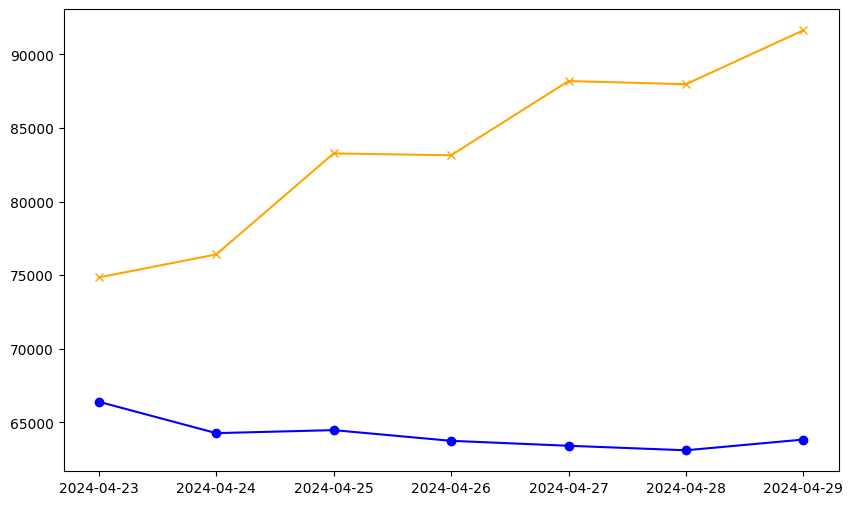

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Tatsächliche Schlusskurse
actual_prices = test_data['close'].iloc[-7:].values

# Vorhergesagte Schlusskurse
predicted_prices = np.array(predicted_prices).flatten()  # Sicherstellen, dass es ein 1D-Array ist

# Fehlerbänder
lower_bound = predicted_prices * 0.95
upper_bound = predicted_prices * 1.05

# Überprüfen der Dimensionen
print("Actual prices shape:", np.shape(actual_prices))
print("Predicted prices shape:", np.shape(predicted_prices))
print("Lower bound shape:", np.shape(lower_bound))
print("Upper bound shape:", np.shape(upper_bound))

# MSE berechnen
mse = np.mean((actual_prices - predicted_prices) ** 2)

# Zeitachse
dates = test_data.index[-7:]
print("Dates length:", len(dates))

# Plot erstellen
plt.figure(figsize=(10, 6))

# Tatsächliche Kurse plotten
plt.plot(dates, actual_prices, label='Tatsächliche Kurse', marker='o', color='blue')

# Vorhergesagte Kurse plotten
plt.plot(dates, predicted_prices, label='Vorhergesagte Kurse', marker='x', color='orange')

# Fehlerbänder hinzufügen
plt.fill_between(dates, lower_bound, upper_bound, color='gray', alpha=0.2, label='Unsicherheit (+/- 5%)')

# Diagrammanpassungen
plt.xlabel('Datum')
plt.ylabel('Schlusskurs (USD)')
plt.title(f'Tatsächlicher vs. vorhergesagter Kurs (MSE: {mse:.2f})')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Plot anzeigen
plt.show()
